In [1]:
%reload_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions, precondition_functions_v3, precondition_functions_v2
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn


In [3]:
jax.devices()

[cuda(id=0)]

In [4]:
key = jax.random.PRNGKey(1)

2025-02-26 16:32:44.220105: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
task = get_task("mixture_rw_2d")
prior = task.get_prior()
simulator = task.get_simulator()

In [6]:
data = task.get_data(key, 500_000, 2)

In [7]:
sde, weight_fn = init_sde(data, name="VESDE",  sigma_max=5., T_min=1e-1)

In [8]:
sde, weight_fn = init_sde(data, name="VPSDE", beta_max=15., beta_min=1e-2)

In [9]:
sde.std(sde.T_min)

Array(0.0291398, dtype=float32, weak_type=True)

In [10]:
sde.mu(sde.T_max)

Array(0.02345902, dtype=float32, weak_type=True)

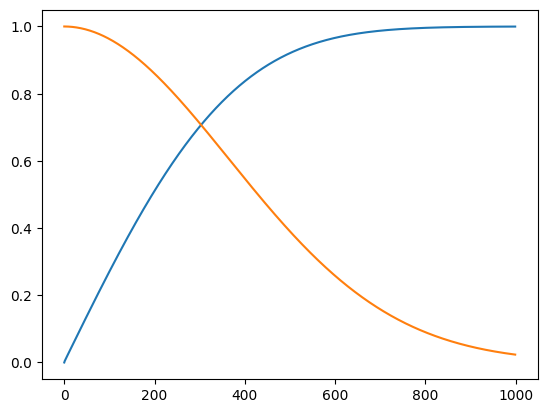

In [11]:
plt.plot(sde.std(jnp.linspace(0, 1, 1000)))
plt.plot(sde.mu(jnp.linspace(0, 1, 1000)))

In [12]:
key, key_init = jax.random.split(key)

In [13]:
c_in, c_noise, c_out = precondition_functions_v2(sde)
init_fn, score_net = build_score_mlp(2, num_hidden=5,c_in=c_in, c_noise=c_noise, c_out=c_out)
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn, control_variate=False, control_variate_cutoff=1.)

In [ ]:
theta_batch, x_batch = batch_sampler(key_init+1, 10)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

E0226 16:32:58.161763 3515768 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: INTERNAL: Failed to allocate 4000000 bytes for new constant


XlaRuntimeError: INTERNAL: Failed to allocate 4000000 bytes for new constant

: 

In [307]:
params = init_fn(key_init, jnp.ones((10,)), theta_batch, x_batch)

In [308]:
score_net(params, jnp.ones((10,)), theta_batch, x_batch).shape

(10, 1, 2)

In [309]:
loss_fn(params, key,theta_batch, x_batch)

Array(0.253, dtype=float32)

In [310]:

schedule = optax.cosine_onecycle_schedule (
    200_000, 5e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(100), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [311]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [312]:
for i in range(20):
    l = 0.
    for _ in range(10000):
        key, key_batch = jax.random.split(key)
        theta_batch, x_batch = batch_sampler(key_batch, 1000)
        loss, params, opt_state = update(params, key, opt_state, theta_batch, x_batch)
        l += loss/10000
    print(l)

16.783333
16.714144
16.593023
16.345253
16.097286
16.064575
15.938217
16.019493
15.964681
15.952192
15.998015


KeyboardInterrupt: 

In [313]:
key = jax.random.PRNGKey(7)
theta_o = prior.sample(key)
num_obs = 6
x_o = simulator(key, theta_o, num_obs)
print(theta_o)


[-1.691  1.605]


In [314]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn, GaussMixtureScoreFn, UncorrectedScoreFn_improved

In [315]:
# jax enable 64 bit precision by default
import jax
#jax.confi<g.update("jax_enable_x64", True)

In [460]:
score_fn = FNPEScoreFn(score_net, params, sde, prior)
score_fn = UncorrectedScoreFn(score_net, params, sde,prior)
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
#score_fn = CorrectedScoreFn(score_net, params, sde, prior)
score_fn2 = GaussMixtureScoreFn(score_net, params, sde, prior)

In [500]:
key = jax.random.PRNGKey(8)
theta_o = prior.sample(key)
num_obs = 11
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[1.433 1.948]


In [501]:
score_fn2 = GaussMixtureScoreFn(score_net, params, sde, prior)

In [513]:
# This has exponentially growing complexity :( But can be reduced, but we dont do that here we just truncate at some point
# The above not very usefull in pratice

score_fn2.estimate_hyperparameters(x_o, (d,), key, reduce_compontents=True, K=2, max_components_scale=0,min_components=5000)

In [514]:
score_fn2.correction_term(jnp.ones_like(theta_o)*(-2.), jnp.array([0.5]), jnp.array([0.5]))

Num components  4
Num components  8
Num components  16
Num components  32
Num components  64
Num components  128
Num components  256
Num components  512
Num components  1024
Num components  2048
Num components  4096
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000
Num components  5000


Array(28.974, dtype=float32)

In [515]:
score_fn2.correction_term_fn(jnp.ones_like(theta_o)*(-2.), jnp.array([0.1]))

Array([-54.302,  -2.124], dtype=float32)

In [516]:
score_fn2(jnp.array([0.1]),jnp.ones_like(theta_o)*(-3.), x_o=x_o)

Array([20.218,  8.113], dtype=float32)

In [517]:
correction_vals = jax.vmap(score_fn2.correction_term_fn, in_axes=(None, 0))(theta_o+6, jnp.linspace(5e-3,1,100))

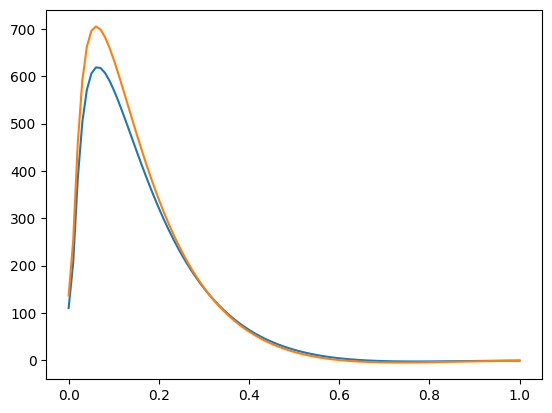

In [518]:
plt.plot(jnp.linspace(0,1,100), correction_vals)

In [519]:
correction_vals_theta = jax.vmap(score_fn2.correction_term_fn, in_axes=(0, None))(jax.random.normal(jax.random.key(0), shape=(100,2)), jnp.array(0.1))

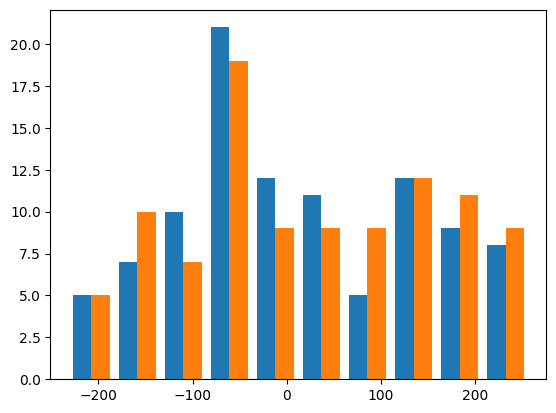

In [520]:
_ = plt.hist(correction_vals_theta, bins=10)

In [521]:

from markovsbi.sampling.sample import Diffuser, clip_transform
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM

kernel = EulerMaruyama(score_fn2)
time_grid = jnp.linspace(sde.T_min, sde.T_max, 500)
sampler = Diffuser(kernel, time_grid, (d,), transform_state=clip_transform(-3,3))


In [522]:
traces = jax.vmap(sampler.simulate, in_axes=(0,None))(jax.random.split(key,(100,)), x_o)

(-5.0, 5.0)

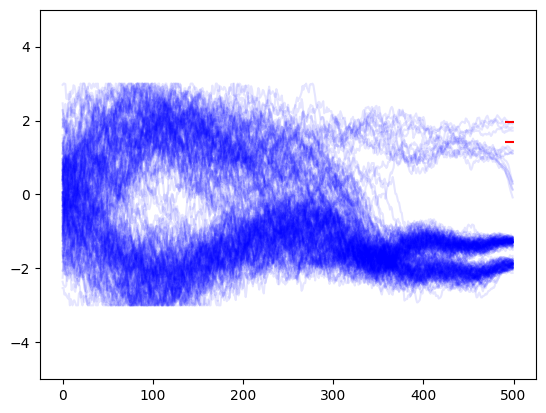

In [523]:
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, 490, 500, color="red")
plt.ylim(-5,5)

In [497]:
import torch
import numpy as np

samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 1000), x_o)

true_posterior = task.get_true_posterior(x_o)
true_samples = true_posterior.sample(jax.random.PRNGKey(1), (1000,))
true_samples = torch.tensor(np.array(true_samples))

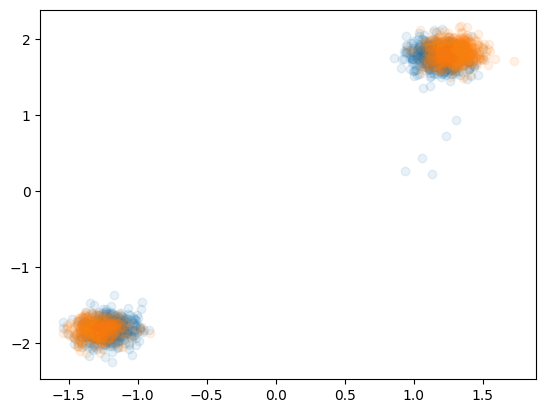

In [498]:
from sbi.analysis import pairplot
import numpy as np
from sympy import limit

plt.scatter(samples[:,0], samples[:,1], alpha=0.1)
plt.scatter(true_samples[:,0], true_samples[:,1], alpha=0.1)


In [499]:
from sbi.utils.metrics import c2st

c2st(torch.tensor(np.array(samples))[:1000], true_samples[:1000])

tensor(0.6395, dtype=torch.float64)

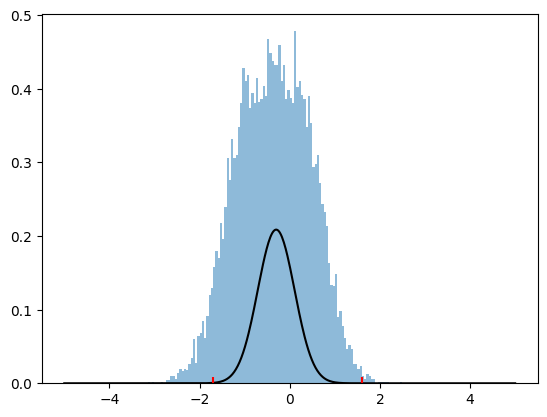

In [31]:
true_posterior = task.get_true_posterior(x_o)
l = jnp.linspace(-5, 5, 500)
logpdf = true_posterior.log_prob(l.reshape(-1,1))

plt.hist(samples.flatten(), bins=200, density=True, range=(-5,5), alpha=0.5)
plt.plot(l, jnp.exp(logpdf), color="black")
plt.vlines(theta_o, 0, jnp.exp(true_posterior.log_prob(theta_o)), color="red")